In [1]:
import pandas as pd
import numpy as np
# from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from automl.data import Dataset
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor

In [2]:
FILE = Path(".").absolute().resolve()
DATADIR = FILE / "data"
# ["bike_sharing_demand", "brazilian_houses", "superconductivity", "wine_quality", "yprop_4_1"]
dataset = Dataset.load(DATADIR, "brazilian_houses", 1)
X_train, y_train, X_test, y_test = dataset.load_test_train()
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [3]:
reg1 = RandomForestRegressor(random_state=42)
reg1.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [4]:
result = permutation_importance(reg1, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

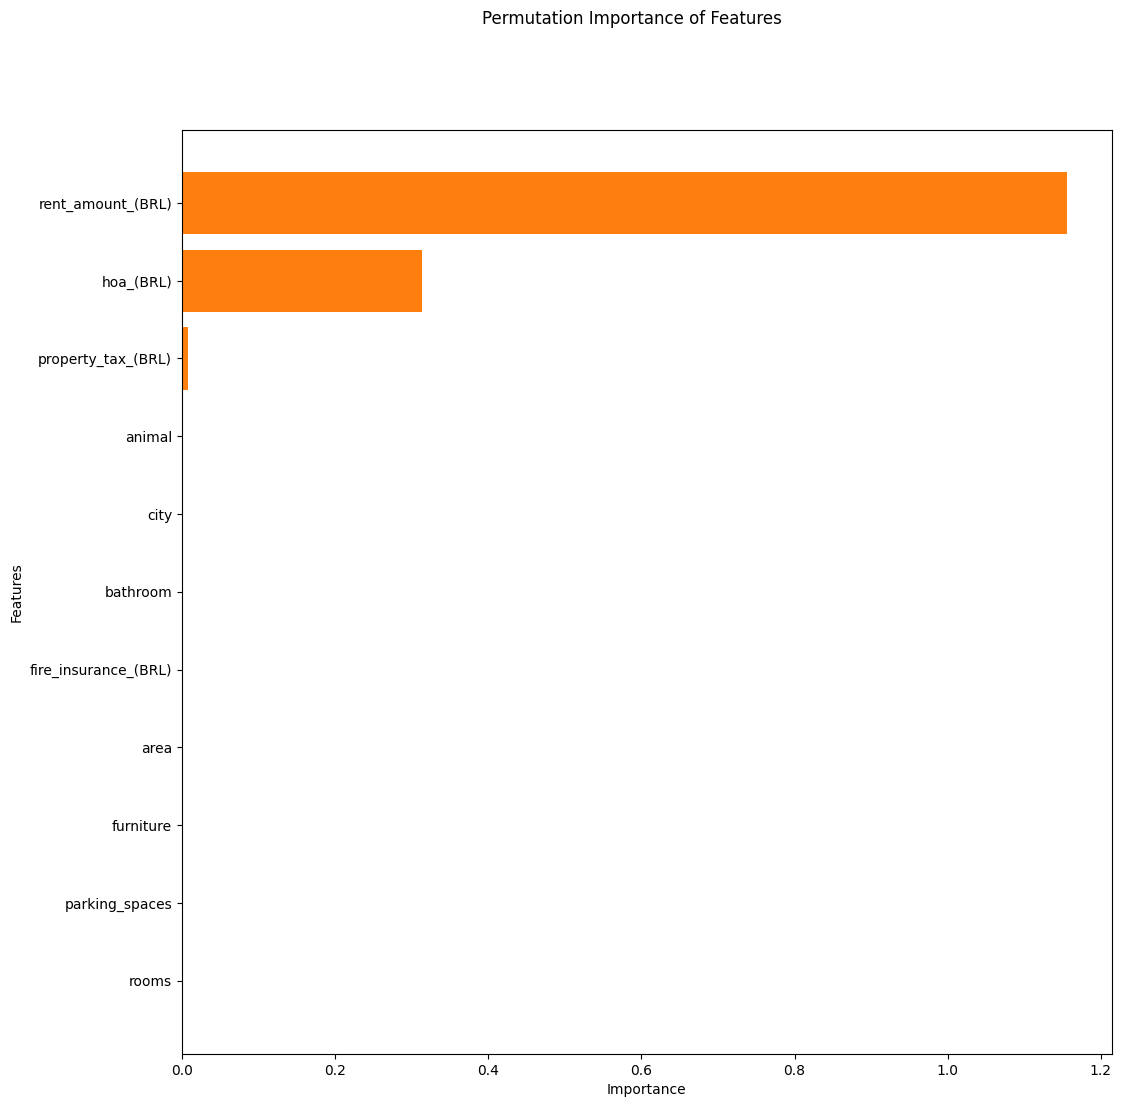

In [5]:
perm_sorted_idx = result["importances_mean"].argsort()
fig1, ax1 = plt.subplots(figsize=(12, 12))
plt.barh(X.columns[perm_sorted_idx], result["importances_mean"][perm_sorted_idx].T)
y_pos = np.arange(len(X.columns[perm_sorted_idx]))
ax1.barh(y_pos, result["importances_mean"][perm_sorted_idx], align="center")
ax1.set_yticks(y_pos, labels=X.columns[perm_sorted_idx])
ax1.set_ylabel('Features')
ax1.set_xlabel('Importance')
fig1.suptitle('Permutation Importance of Features')
plt.show()

Text(0.5, 0, 'Importance')

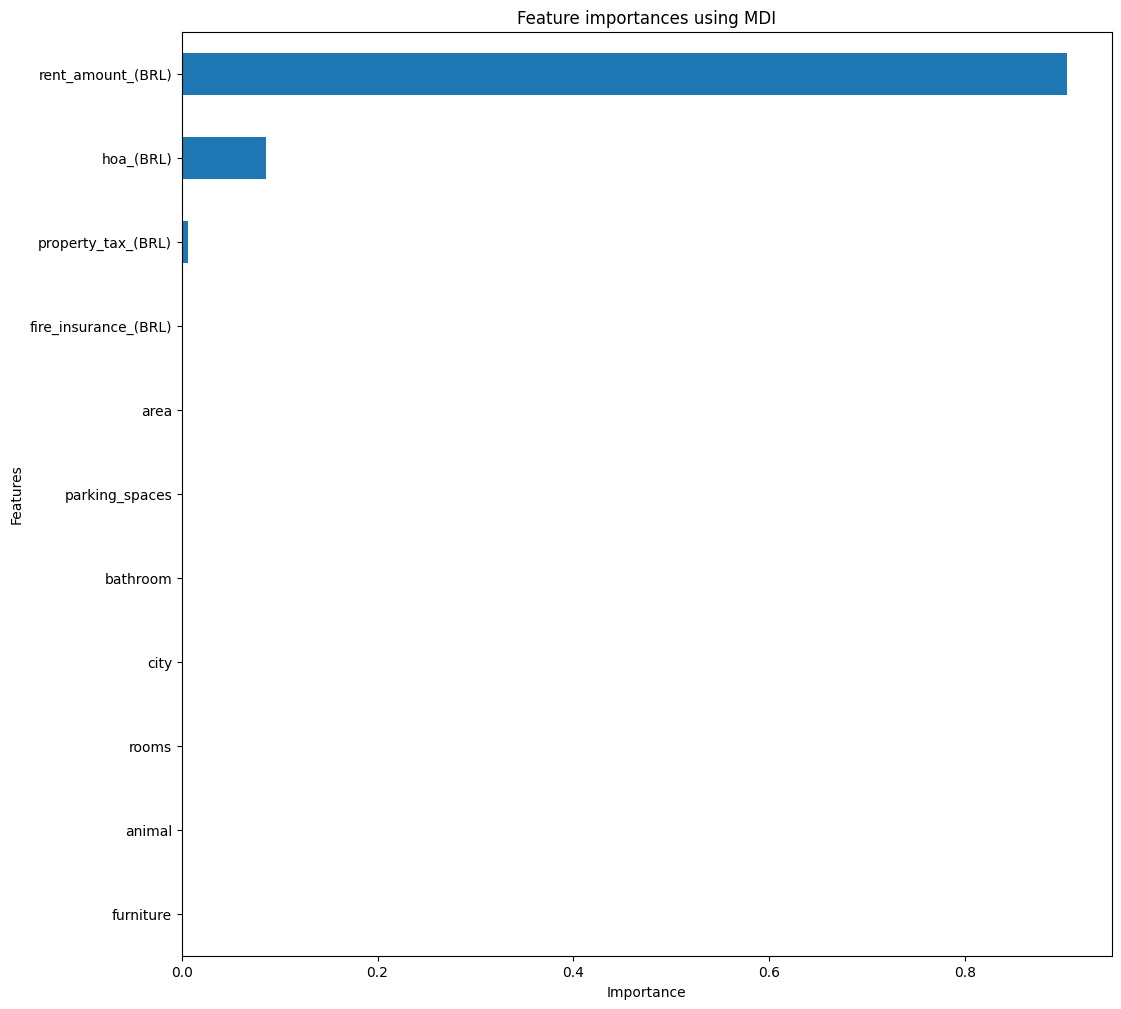

In [6]:
mdi_importances = pd.Series(reg1.feature_importances_, index=X_train.columns)
tree_importance_sorted_idx = np.argsort(reg1.feature_importances_)
fig2, ax2 = plt.subplots(figsize=(12, 12))
mdi_importances.sort_values().plot.barh(ax=ax2)
ax2.set_title("Feature importances using MDI")
ax2.set_ylabel("Features")
ax2.set_xlabel("Importance")

In [7]:
num_features_to_select = int(len(X_train.columns) * 0.75) # Select top 75% of features
selected_columns_permuted = X_train.columns[perm_sorted_idx][-num_features_to_select:]
selected_columns_tree = X_train.columns[tree_importance_sorted_idx][-num_features_to_select:]
X_perm = X_train[selected_columns_permuted]
X_tree = X_train[selected_columns_tree]
print(f"Original no. of features: {len(X_train.columns)} \nNo. of features selected: {len(X_perm.columns)}")
print(f"Permuted features: {X_perm.columns}, \nTree features: {X_tree.columns}")

Original no. of features: 11 
No. of features selected: 8
Permuted features: Index(['area', 'fire_insurance_(BRL)', 'bathroom', 'city', 'animal',
       'property_tax_(BRL)', 'hoa_(BRL)', 'rent_amount_(BRL)'],
      dtype='object'), 
Tree features: Index(['city', 'bathroom', 'parking_spaces', 'area', 'fire_insurance_(BRL)',
       'property_tax_(BRL)', 'hoa_(BRL)', 'rent_amount_(BRL)'],
      dtype='object')


In [8]:
print(f"Baseline accuracy on test data: {reg1.score(X_test, y_test)}")

Baseline accuracy on test data: 0.9873270809761956


In [9]:
reg_perm = RandomForestRegressor(random_state=42)
reg_perm.fit(X_perm, y_train)
print(f"Baseline accuracy on permuted data: {reg_perm.score(X_test[selected_columns_permuted], y_test)}")

Baseline accuracy on permuted data: 0.9874382588360539


In [10]:
reg_tree = RandomForestRegressor(random_state=42)
reg_tree.fit(X_tree, y_train)
print(f"Baseline accuracy on tree data: {reg_tree.score(X_test[selected_columns_tree], y_test)}")

Baseline accuracy on tree data: 0.9871733918875295
